In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import spacy
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from transformers import TFBertModel
from transformers import BertTokenizer
import tensorflow_hub as hub
import tensorflow_text as text
import pickle

In [2]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [3]:
print(tf. __version__)

2.10.0


### **Plan of Action**

- Load the data
- Drop unnecessary columns and rows
- Removal of stop words.
- Feature engineering;
    - TRANSFORMER
- Begin modelling
    - Algorithms to use;
        - BERT
- Evaluation;
    - F1-score_macro
    - AUC
    - ROC

In [5]:
df_clean = pd.read_csv('../../cleaned_reviews.csv')

In [6]:
df_clean.shape

(17340, 4)

In [7]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [8]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)

**Checking for Null Vaules and Duplicates**

In [9]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [10]:
df_clean.dropna(inplace=True)

In [ ]:
df_clean.shape

(17337, 2)

: 

: 

: 

: 

: 

In [11]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [15]:
# Mapping was changed due to the use of a neural network architecture
sentiment_mapping = {'negative':0,'neutral':1,'positive':2} 
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)
df_clean.drop(columns=['sentiments'],inplace=True)

In [16]:
df_clean

,cleaned_review,sentiment_label
0,i wish would have gotten one earlier love it a...,2
1,i ve learned this lesson again open the packag...,1
2,it is so slow and lags find better option,1
3,roller ball stopped working within months of m...,1
4,i like the color and size but it few days out ...,1
...,...,...
17335,i love this speaker and love can take it anywh...,2
17336,i use it in my house easy to connect and loud ...,2
17337,the bass is good and the battery is amazing mu...,2
17338,love it,2


In [17]:
labels = tf.keras.utils.to_categorical(df_clean.sentiment_label.values, num_classes=3, dtype='int8')

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train,y_test= train_test_split(
                                            df_clean['cleaned_review'],labels,test_size=.2,random_state=42, 
                                            stratify=labels)


In [35]:
# Model Building
# BERT LAYERS
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string,name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
intermediate_layer1 = tf.keras.layers.Dense(512, activation="relu", name="intermediate_layer1")(outputs["pooled_output"])
# intermediate_layer2 = tf.keras.layers.Dense(256, activation="relu", name="intermediate_layer2")(intermediate_layer1)

output_layer = tf.keras.layers.Dense(3,activation="softmax", name="output_layer")(intermediate_layer1)

In [36]:
model = tf.keras.Model(inputs=[text_input], outputs=output_layer)

In [37]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [38]:
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['acc'])

In [39]:
bert_model_history = model.fit(X_train,y_train,epochs=4,validation_split=.20,batch_size=16)

Epoch 1/4
694/694 [==============================] - 1797s 3s/step - loss: 0.7622 - acc: 0.6585 - val_loss: 0.6393 - val_acc: 0.7311
Epoch 2/4
694/694 [==============================] - 1873s 3s/step - loss: 0.6627 - acc: 0.7081 - val_loss: 0.6093 - val_acc: 0.7401
Epoch 3/4
694/694 [==============================] - 1481s 2s/step - loss: 0.6293 - acc: 0.7241 - val_loss: 0.6113 - val_acc: 0.7469
Epoch 4/4
694/694 [==============================] - 1405s 2s/step - loss: 0.6154 - acc: 0.7269 - val_loss: 0.6652 - val_acc: 0.7008


In [40]:
# Evaluate on the Test Set

score = model.evaluate(X_test, y_test, verbose=1)

109/109 [==============================] - 361s 3s/step - loss: 0.6609 - acc: 0.6900


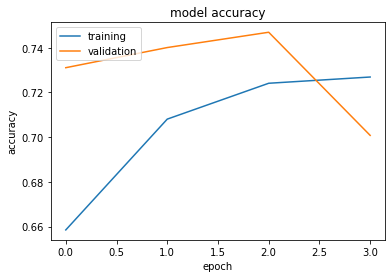

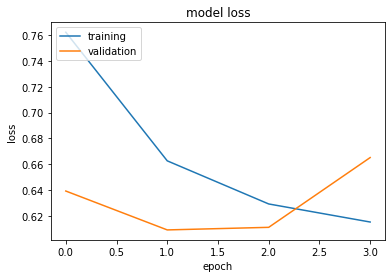

In [41]:
# Model Performance Charts

plt.plot(bert_model_history.history['acc'])
plt.plot(bert_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

plt.plot(bert_model_history.history['loss'])
plt.plot(bert_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training','validation'], loc='upper left')
plt.show()

In [43]:
# Saving the model
model.save("saved_model_hub/bert_model")

INFO:tensorflow:Assets written to: saved_model_hub/bert_model\assets


INFO:tensorflow:Assets written to: saved_model_hub/bert_model\assets


### **Classification report**

109/109 [==============================] - 358s 3s/step
              precision    recall  f1-score   support

           0       0.59      0.03      0.06       307
           1       0.71      0.46      0.56      1260
           2       0.68      0.95      0.80      1901

    accuracy                           0.69      3468
   macro avg       0.66      0.48      0.47      3468
weighted avg       0.69      0.69      0.64      3468



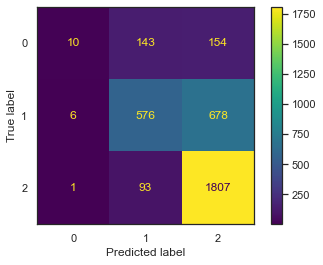

In [44]:
# Classification report test data
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_true=np.argmax(y_test, axis=1)
y_pred_test = model.predict(X_test)
y_pred_test=np.argmax(y_pred_test, axis=1)
sns.set_theme(style='white')
def class_report(model,y_true,pred):
    print(classification_report(y_true,pred))
    cm = confusion_matrix(y_true,pred,labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
    disp.plot()
    plt.show()


class_report(model,y_true,y_pred_test) 

# Original mapping
# sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}

# New mapping
# negative --> 0
# neutral ---> 1
# positive --> 2

In [ ]:
# Predictions on unseen data

In [45]:
reviews =[ "I can't believe I wasted my money on this keyboard and mouse",
            "I really love this device",
            "It's quite good, but not so great. They can do better",
            "I hate this device, terrible!!!",
            "Where the hell is my refund for this damn product (mouse)",
            "I believe Ebay is so much better than the crap that is HERE!!!",
            "worst keyboard ever",
            "distasteful to the fullest!!!",
            "spoilt on the first day",
            "never shopping here again, waste of money"]

In [46]:
y_pred = model.predict(reviews)

1/1 [==============================] - 4s 4s/step


In [47]:
predictions = np.argmax(y_pred, axis = 1)
predictions

array([2, 2, 1, 2, 1, 2, 1, 2, 1, 1], dtype=int64)

In [ ]:
# New mapping
# negative --> 0
# neutral ---> 1
# positive --> 2

### **Conclusion**
- BERT is a powerful model but needs to be fine-tuned to properly make use of it, as seen from the confusion matrix, there is a lot of misclassifications. 
- A larger dataset could aid in the aid and also a balanced dataset.
- Increasing the epochs or tuning the optimiser or even adding more layers could aid in the model's performance.
